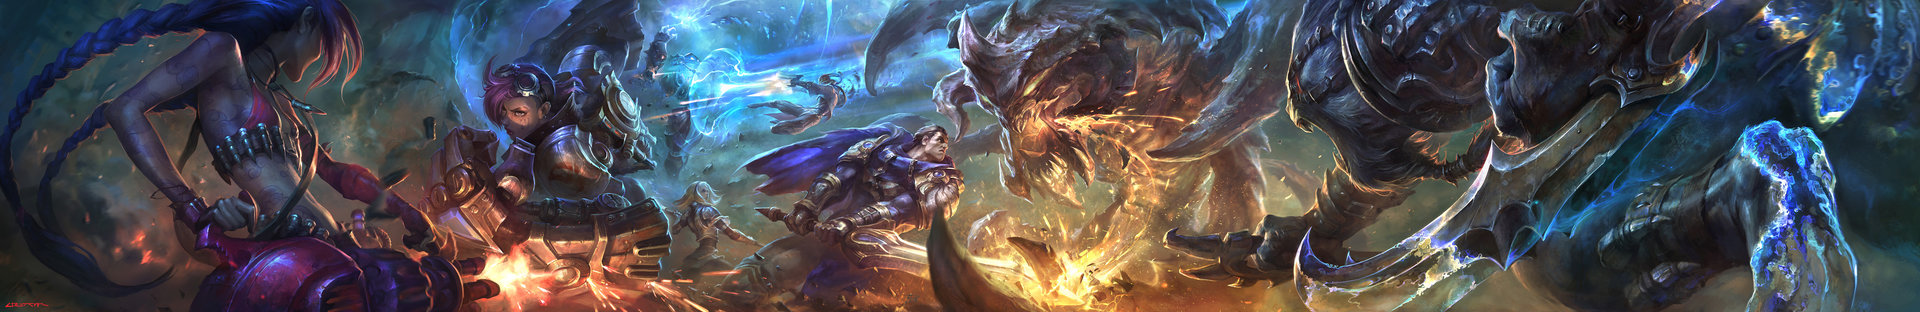

# Match Prophet

---



# Introdução

Todos nós estamos familiarizados com jogos, sejam os clássicos como *Super Mario* ou mais inovadores como os *MOBA(Mobile Online Battle Arena)*. De toda forma, muitos deles tratam de um objetivo geral: vencer.

Diante disso, temos o exemplo de um dos jogos mais famosos da atualidade, o *League of Legends*. Nele, dois times rivais devem disputar uma partida e tentar vencê-la, onde cada time é composto por 5 jogadores e seus personagens.

Visto a popularidade do jogo e seu cunho competitivo, é natural que quem desfruta do jogo pense cada vez mais em estratégias para vencer. **Mas ele precisa jogar para saber o funciona e o que não.**

Mas será que essa é a única forma? Jogar manualmente e individualmente várias vezes e tentar diversas estratégias diferentes para talvez saber as melhores decisões? Nós pensamos que **não**. O jogo possui muitas variáveis, inclusive aquelas cujos jogadores não podem controlar a priori.

Então, talvez um computador seja mais apropriado para a tarefa; teríamos a possibilidade de estudar muitas partidas e estratégias diferentes, combinando os mais diversos cenários reais e as possíveis variáveis que definem o rumo do jogo. Tudo isso de forma que não seja preciso gastar horas dentro de partidas.

Nos vemos então com o seguinte questionamento: *Como realizar predições de partidas? Como definir os atributos que influenciam um time a vencer?*

# Dados e sua obtenção

Utilizamos a *api* oficial *Riot*, desenvolvedora do jogo, que nos proporcionou dados reais de partidas recentes para que pudéssemos ter uma análise confiável e o mais próximo possível do que acontece no cotidiano dos jogadores.

No começo do projeto, enquanto estudávamos as possibilidades de obtenção de dados, percebemos a necessidade de registrar um “produto” no site oficial de desenvolvedores da *Riot* e fizemos o processo para conseguir uma chave de desenvolvedor para ser utilizada nas requisições da *api* como forma de autenticação. Por razões de privacidade e segurança, é explicitado que tal chave não deve ser compartilhada com pessoas fora do projeto, portanto ela será omitida da especificação do projeto.

Como aconselhado na documentação oficial da *api*, utilizamos também um *Wrapper* na linguagem Python para facilitar o processo de tratamento das requisições.

O que nos leva aos atributos em si. **Quais foram os escolhidos?**

A pergunta pode parecer simples, mas a resposta precisou de um refinamento que durou até as fases finais do projeto. No início, ao analisar as opções de dados disponíveis sobre uma partida, optamos por gerar dados por partida; cada uma possui uma quantidade de jogadores e, para cada um, seu histórico é analisado partida por partida a fim de gerar dados baseados mais confiáveis para cada jogador. No fim, cada linha do DataSet gerado representa uma partida, que por sua vez analisou a performance dos seus jogadores e de duas partidas passadas.

De forma mais específica, escolhemos os seguintes atributos, por time:
Ouro

*   **Ouro**
*   **Proporção de Abates/Mortes/Assistências**
*   **Maestria com o personagem**
*   **Objetivos Neutros:**
  -  Torres
  -  Dragões
  -  Barões
*   **Vencedor**

Como será explicado mais adiante, esses dados não foram o suficiente para gerar uma análise frutífera. Assim, foi necessário fazer um tratamento para que pudessem representar melhor a vantagem de um time em relação ao outro, através da diferença entre os possíveis valores por exemplo.


# Predição de Partidas de LOL

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import graphviz

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold


## Dataset pré partida

In [84]:
matches = pd.read_csv('./dataset/data.csv', index_col='id')

In [85]:
matches = matches.drop('Unnamed: 0', axis=1, errors='ignore')
matches.head(5)

,blue_gold,blue_kda,blue_win,blue_towers,blue_barons,blue_dragons,blue_mastery,red_gold,red_kda,red_win,red_towers,red_barons,red_dragons,red_mastery,win,teamId
id,,,,,,,,,,,,,,,,
BR1_2332023009,43.998134,3.712047,0.68,5.56,0.36,1.64,1484578,44.774883,4.632173,0.56,5.00,0.48,1.52,865363,1,100
BR1_2331869184,49.353656,4.116188,0.48,5.20,0.32,1.44,1143966,47.677913,4.681955,0.56,6.08,0.64,1.88,187976,1,200
BR1_2331846144,43.113285,3.980095,0.48,4.88,0.48,1.52,227362,41.531938,3.264168,0.68,5.52,0.36,1.68,419139,1,200
BR1_2331699359,43.132938,4.172079,0.36,4.56,0.20,1.52,1241941,40.116949,3.484472,0.64,5.60,0.64,2.00,3263248,1,200
BR1_2331717806,48.039552,2.728314,0.64,5.64,0.32,1.52,412685,42.034418,3.150270,0.56,5.72,0.48,1.88,323030,1,200


In [86]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, BR1_2332023009 to BR1_2331989955
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   blue_gold     506 non-null    float64
 1   blue_kda      506 non-null    float64
 2   blue_win      506 non-null    float64
 3   blue_towers   506 non-null    float64
 4   blue_barons   506 non-null    float64
 5   blue_dragons  506 non-null    float64
 6   blue_mastery  506 non-null    int64  
 7   red_gold      506 non-null    float64
 8   red_kda       506 non-null    float64
 9   red_win       506 non-null    float64
 10  red_towers    506 non-null    float64
 11  red_barons    506 non-null    float64
 12  red_dragons   506 non-null    float64
 13  red_mastery   506 non-null    int64  
 14  win           506 non-null    int64  
 15  teamId        506 non-null    int64  
dtypes: float64(12), int64(4)
memory usage: 67.2+ KB


In [87]:
matches.describe()

,blue_gold,blue_kda,blue_win,blue_towers,blue_barons,blue_dragons,blue_mastery,red_gold,red_kda,red_win,red_towers,red_barons,red_dragons,red_mastery,win,teamId
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,5.060000e+02,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,5.060000e+02,506.000000,506.000000
mean,46.401959,3.676353,0.516070,5.003896,0.370107,1.501521,1.806102e+06,46.795770,3.664195,0.526861,5.040479,0.370386,1.497956,1.013678e+06,0.547431,158.695652
std,7.982566,0.994201,0.118201,1.063265,0.173884,0.469817,1.684340e+06,8.143568,0.899723,0.117764,1.018517,0.170324,0.490444,1.121114e+06,0.498238,49.286777
min,32.219266,1.644161,0.200000,2.360000,0.000000,0.000000,2.551000e+03,34.685086,1.903048,0.240000,2.520000,0.000000,0.000000,7.510000e+02,0.000000,100.000000
25%,40.962579,2.949131,0.440000,4.320000,0.240000,1.250000,5.738642e+05,41.201688,3.024496,0.440000,4.360000,0.280000,1.320000,2.569750e+05,0.000000,100.000000
50%,44.339631,3.576341,0.520000,4.920000,0.360000,1.560000,1.295648e+06,44.144173,3.562073,0.520000,5.040000,0.400000,1.560000,6.092975e+05,1.000000,200.000000
75%,49.235658,4.230129,0.600000,5.680000,0.480000,1.800000,2.591415e+06,49.667982,4.187964,0.600000,5.680000,0.480000,1.800000,1.359317e+06,1.000000,200.000000
max,71.319835,8.905238,0.920000,9.120000,1.000000,3.040000,1.087682e+07,73.266823,8.647387,0.840000,8.520000,0.880000,2.782609,7.323170e+06,1.000000,200.000000


Observando o dataset, vemos que temos informações para os dois times, mas desse jeito não dá pra saber de cara se o time do jogador estava na vantagem ou desvantagem, então o que fizemos foi a diferença dos valores de cada time, descobrindo, assim, qual time tem a vantagem em cada aspecto.

In [88]:
attr_cols = []
for col in matches.columns:
    if(col.startswith('blue_')):
        attr_name = col[5:]
        attr_cols.append(attr_name)

mul = matches.loc[:, 'teamId'].apply(lambda x: 1 if x == 100 else -1)
df = pd.DataFrame(columns=[f'diff_{attr}'for attr in attr_cols])

for attr in attr_cols:
    v = (matches.loc[:, f'blue_{attr}'] - matches.loc[:, f'red_{attr}']) * mul
    df.loc[:, f'diff_{attr}'] = v

df['win'] = matches['win']
df

,diff_gold,diff_kda,diff_win,diff_towers,diff_barons,diff_dragons,diff_mastery,win
id,,,,,,,,
BR1_2332023009,-0.776749,-0.920127,0.12,0.56,-0.12,0.12,619215,1
BR1_2331869184,-1.675742,0.565768,0.08,0.88,0.32,0.44,-955990,1
BR1_2331846144,-1.581346,-0.715927,0.20,0.64,-0.12,0.16,191777,1
BR1_2331699359,-3.015988,-0.687608,0.28,1.04,0.44,0.48,2021307,1
BR1_2331717806,-6.005135,0.421956,-0.08,0.08,0.16,0.36,-89655,1
...,...,...,...,...,...,...,...,...
BR1_2332440748,2.679372,0.033069,-0.16,0.36,-0.24,-0.56,1257084,0
BR1_2332395319,-9.955786,-0.662177,0.12,0.92,-0.00,0.64,72941,1
BR1_2332392870,-6.470754,-2.200457,-0.04,-0.64,0.04,0.28,62009,1


### Correlação dos Dados

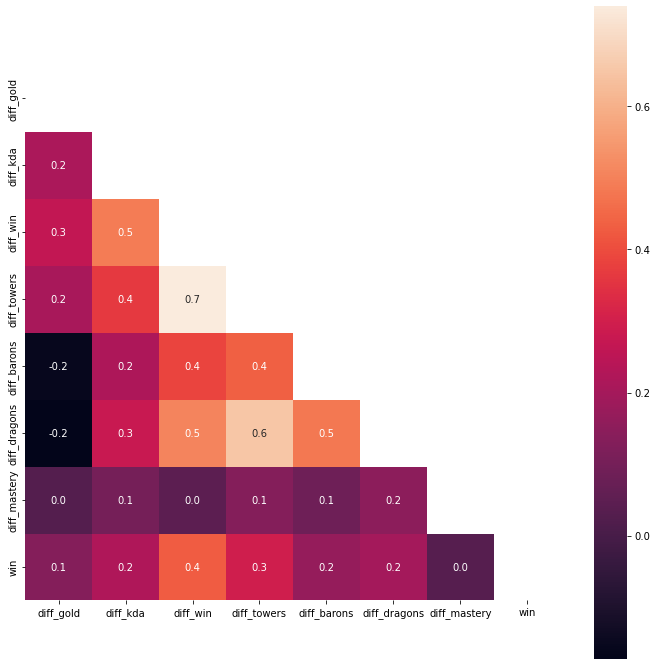

In [89]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, fmt='.1f', mask=mask, square=True);

### Resultados com dados pré partida

In [90]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [91]:
x_train, y_train = df_train.drop('win', axis=1).values, df_train['win'].values
x_test, y_test = df_test.drop('win', axis=1).values, df_test['win'].values

Normalizamos os nossos dados, e a nossa ideia é de testar vários modelos, então fizemos um Grid Search para KNN, SVM, Decision Tree e Random Forest. Em todos os modelos, a acurácia foi em torno de 60 a 70%, mas o que foi curioso é que o fator mais decisivo foi apenas a diferença entre os jogos ganhos.

#### KNN

In [92]:
params = {
  'model__n_neighbors': [i for i in range(3, 9, 2)],
  'model__weights': ['uniform', 'distance'],
  'model__metric': ['minkowski', 'manhattan']

}

pipe = Pipeline([
  ('scaler', StandardScaler()),
  ('model', KNeighborsClassifier())
]) 
grid = GridSearchCV(pipe, params)
grid.fit(x_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__metric,param_model__n_neighbors,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.002067,0.000491,0.006271,0.001154,minkowski,5,uniform,"{'model__metric': 'minkowski', 'model__n_neigh...",0.617284,0.654321,0.580247,0.666667,0.5375,0.611204,0.047671,1
3,0.001912,0.000278,0.001931,0.000270,minkowski,5,distance,"{'model__metric': 'minkowski', 'model__n_neigh...",0.604938,0.666667,0.592593,0.654321,0.5375,0.611204,0.046375,1
5,0.001891,0.000299,0.001804,0.000105,minkowski,7,distance,"{'model__metric': 'minkowski', 'model__n_neigh...",0.567901,0.666667,0.617284,0.654321,0.5250,0.606235,0.053207,3
4,0.001917,0.000118,0.005407,0.000368,minkowski,7,uniform,"{'model__metric': 'minkowski', 'model__n_neigh...",0.580247,0.666667,0.604938,0.654321,0.5125,0.603735,0.055491,4
8,0.002237,0.000453,0.006602,0.000590,manhattan,5,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.580247,0.641975,0.567901,0.666667,0.5500,0.601358,0.044984,5


#### SVM

In [93]:
params = {
    'model__C': [1, 10, 100, 1000], 
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': [0.001, 0.0001], 

}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())
]) 
grid = GridSearchCV(pipe, params)
grid.fit(x_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__gamma,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.010117,0.000752,0.003430,0.000596,100,0.0001,rbf,"{'model__C': 100, 'model__gamma': 0.0001, 'mod...",0.641975,0.753086,0.617284,0.654321,0.6625,0.665833,0.046223,1
5,0.008913,0.000789,0.002441,0.000235,10,0.001,rbf,"{'model__C': 10, 'model__gamma': 0.001, 'model...",0.654321,0.753086,0.617284,0.654321,0.6500,0.665802,0.045795,2
4,0.021544,0.001753,0.001327,0.000115,10,0.001,linear,"{'model__C': 10, 'model__gamma': 0.001, 'model...",0.654321,0.753086,0.604938,0.666667,0.6000,0.655802,0.055291,3
6,0.021676,0.001670,0.001323,0.000140,10,0.0001,linear,"{'model__C': 10, 'model__gamma': 0.0001, 'mode...",0.654321,0.753086,0.604938,0.666667,0.6000,0.655802,0.055291,3
9,0.009396,0.000837,0.002616,0.000339,100,0.001,rbf,"{'model__C': 100, 'model__gamma': 0.001, 'mode...",0.654321,0.716049,0.629630,0.679012,0.6000,0.655802,0.039924,3


#### Decision Tree

In [94]:
params = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None] + [2**i for i in range(1, 4)]
}

pipe = Pipeline([
  ('model', DecisionTreeClassifier())
]) 
grid = GridSearchCV(pipe, params, cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(x_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.001457,0.000434,0.000693,0.000231,gini,2,"{'model__criterion': 'gini', 'model__max_depth...",0.703704,0.703704,0.666667,0.617284,0.7000,0.678272,0.033526,1
5,0.002766,0.000873,0.001140,0.000401,entropy,2,"{'model__criterion': 'entropy', 'model__max_de...",0.703704,0.703704,0.641975,0.617284,0.7000,0.673333,0.036553,2
6,0.004360,0.000718,0.001764,0.000799,entropy,4,"{'model__criterion': 'entropy', 'model__max_de...",0.679012,0.666667,0.629630,0.580247,0.6500,0.641111,0.034655,3
2,0.001611,0.000162,0.000505,0.000071,gini,4,"{'model__criterion': 'gini', 'model__max_depth...",0.666667,0.641975,0.641975,0.567901,0.6625,0.636204,0.035641,4
7,0.005254,0.001087,0.001165,0.000459,entropy,8,"{'model__criterion': 'entropy', 'model__max_de...",0.629630,0.679012,0.592593,0.604938,0.6500,0.631235,0.031055,5


##### Plot Decision Tree

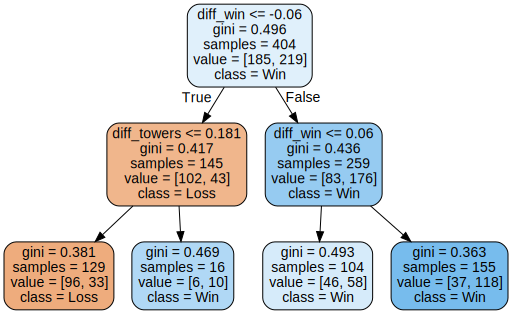

In [95]:
features = df_train.drop(columns='win').columns
dot_data = export_graphviz(grid.best_estimator_['model'], 
                           out_file=None,
                           filled=True,
                           rounded=True,
                           class_names=['Loss', 'Win'],
                           feature_names=features)

graph = graphviz.Source(dot_data)
graph

#### Random Forrest

In [96]:
params = {
  'model__criterion': ['gini', 'entropy'],
  'model__max_depth': [None] + [2**i for i in range(1, 4)],
  'model__n_estimators': [10*i for i in range(1, 21)]
}

pipe = Pipeline([
  ('scaler', StandardScaler()),
  ('model', RandomForestClassifier())
])
grid = GridSearchCV(pipe, params)
grid.fit(x_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
122,0.112745,0.008470,0.009085,0.001701,entropy,4,30,"{'model__criterion': 'entropy', 'model__max_de...",0.679012,0.728395,0.654321,0.703704,0.6500,0.683086,0.029721,1
123,0.139000,0.024308,0.013074,0.006187,entropy,4,40,"{'model__criterion': 'entropy', 'model__max_de...",0.679012,0.691358,0.641975,0.728395,0.6625,0.680648,0.029059,2
34,0.263822,0.007101,0.020265,0.000801,gini,2,150,"{'model__criterion': 'gini', 'model__max_depth...",0.641975,0.765432,0.641975,0.679012,0.6500,0.675679,0.046900,3
137,0.432255,0.055386,0.035038,0.011568,entropy,4,180,"{'model__criterion': 'entropy', 'model__max_de...",0.679012,0.753086,0.641975,0.691358,0.6125,0.675586,0.047700,4
131,0.385183,0.081973,0.035104,0.009019,entropy,4,120,"{'model__criterion': 'entropy', 'model__max_de...",0.654321,0.716049,0.654321,0.691358,0.6500,0.673210,0.026141,5


## Dataset com dados de 10 min de partida
Além do dataset que construímos usando API da Riot, nós também testamos métodos de machine learning em um dataset que usava informações durante o jogo, para ser mais exato durante os 10 primeiros minutos de jogo.
 
Nossa hipótese é que talvez os dados pré-partida não fossem suficientes para predizer o resultado.
 
Esse dataset está disponível no Kaggle: [League of Legends Diamond Ranked Games](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min).


In [97]:
matches = pd.read_csv('./dataset/high_diamond_ranked.csv', index_col='gameId')
matches.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
gameId,,,,,,,,,,,,,,,,,,,,,
4519157822,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
4523371949,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
4521474530,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
4524384067,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4436033771,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [98]:
matches.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

In [99]:
df_train, df_test = train_test_split(matches, test_size=.2)
X, Y = matches.drop('blueWins', axis=1).values, matches['blueWins'].values
x_train, y_train = df_train.drop('blueWins', axis=1).values, df_train['blueWins'].values
x_test, y_test = df_test.drop('blueWins', axis=1).values, df_test['blueWins'].values

### Decision Tree

In [100]:
params = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None] + [2**i for i in range(1, 4)]
}

pipe = Pipeline([
    ('model', DecisionTreeClassifier())
]) 
grid = GridSearchCV(pipe, params, cv=StratifiedKFold(n_splits=10))
grid.fit(x_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.033604,0.001474,0.000933,0.000244,gini,2,"{'model__criterion': 'gini', 'model__max_depth...",0.731985,0.691530,0.719343,0.745570,0.705063,0.746835,0.736709,0.713924,0.721519,0.724051,0.723653,0.016592,1
5,0.042283,0.001018,0.000789,0.000225,entropy,2,"{'model__criterion': 'entropy', 'model__max_de...",0.731985,0.690265,0.719343,0.743038,0.705063,0.721519,0.736709,0.713924,0.721519,0.724051,0.720742,0.014539,2
6,0.084724,0.001416,0.000801,0.000146,entropy,4,"{'model__criterion': 'entropy', 'model__max_de...",0.731985,0.685209,0.719343,0.755696,0.684810,0.727848,0.724051,0.713924,0.721519,0.727848,0.719223,0.020099,3
2,0.063797,0.003867,0.001055,0.000286,gini,4,"{'model__criterion': 'gini', 'model__max_depth...",0.728192,0.690265,0.718078,0.756962,0.684810,0.729114,0.724051,0.713924,0.708861,0.726582,0.718084,0.019562,4
7,0.180684,0.023677,0.000985,0.000348,entropy,8,"{'model__criterion': 'entropy', 'model__max_de...",0.709229,0.694058,0.700379,0.730380,0.670886,0.707595,0.700000,0.693671,0.713924,0.710127,0.703025,0.014812,5


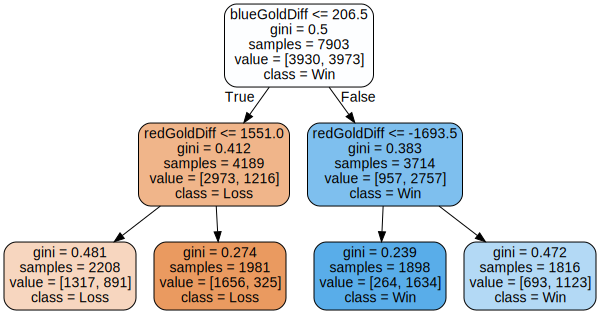

In [101]:
features = df_train.drop(columns='blueWins').columns
dot_data = export_graphviz(grid.best_estimator_['model'], 
                           out_file=None,
                           filled=True,
                           rounded=True,
                           class_names=['Loss', 'Win'],
                           feature_names=features)

graph = graphviz.Source(dot_data)
graph

Podemos perceber que usando os dados obtidos durante o jogo, o atributo que parece controlar se um time vai ganhar ou perder é a diferença de ouro entre os times. Entretanto é interessante perceber que a árvore agora também leva em consideração alguns objetivos bem pertinentes como Dragões obtidos, número de kills e diferença de experiência.

In [102]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
pipe.fit(x_train, y_train)
cross_val_score(pipe, X, Y, cv=5).mean()

0.7312475785373853

### PCA e Logistic Regression

Accuracy: 0.7312475785373853


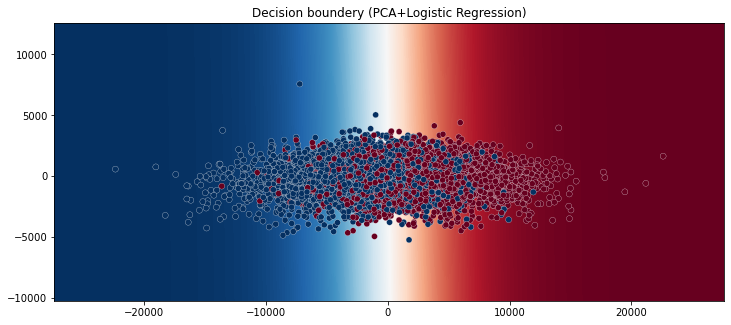

In [103]:
pca = PCA(n_components=2)
data = pca.fit_transform(x_train)
x_axis = data[:, [0]]
y_axis = data[:, [1]]
resolution = 1000
padding = 5000
x_min, x_max = x_axis.min()-padding, x_axis.max()+padding
y_min, y_max = y_axis.min()-padding, y_axis.max()+padding
x_disc = np.linspace(x_min, x_max, resolution)
y_disc = np.linspace(y_min, y_max, resolution)
mesh = np.dstack(np.meshgrid(x_disc, y_disc)).reshape(-1, 2)
pipe.fit(data, y_train)
probs = pipe.predict_proba(mesh)[:, 0]

plt.figure(figsize=(12,6))
plt.title('Decision boundery (PCA+Logistic Regression)')

plt.imshow(
    probs.reshape(resolution, resolution), 
    cmap="RdBu_r",
    extent=(x_min, x_max, y_min, y_max)
)

plt.scatter(data[:, [0]], data[:, [1]], c=y_train, cmap='RdBu', linewidths=.25, edgecolors='white');
print(f'Accuracy: {cross_val_score(pipe, X, Y).mean()}')

É interessante perceber que podemos usar PCA para reduzir as nossas features para somente 2 componentes e ainda manter uma acurácia no nível dos outros modelos.
 
Além disso, pela superfície de decisão podemos perceber que as partidas podem ser bem preditas até um certo ponto. No meio, onde a diferença entre os times é balanceada, o algoritmo não consegue distinguir entre vitória e derrota nos 10 primeiros minutos de uma forma eficaz.

## Um Experimento
 
Após esses resultados nós ficamos curiosos para saber realmente o quanto a diferença de ouro impacta na predição da partida.
 
Decidimos então criar um modelo de ML, no qual o treinamento é pegar a diferença mediana de ouro nas partidas que foram vitória e a predição é simplesmente verificar se a diferença de ouro é maior ou menor que essa mediana.
 



In [104]:
class GoldDiscriminator():
    def fit(self, x, y):
        self.gold_diff = x[:, 15] # gold diff feature
        self.mean_gold_diff= np.median(self.gold_diff)
    def predict(self, x):
        return x[:, [15]] > self.mean_gold_diff

model = GoldDiscriminator()
model.fit(x_train, y_train.ravel())
y_pred = model.predict(x_test)

Mean Accuracy (n_splits=5): 0.7230476092861169


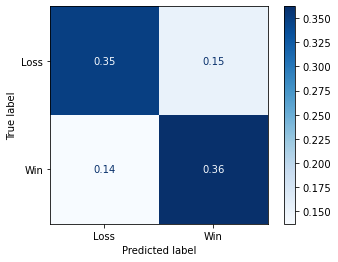

In [105]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
scores = []
for train_index, test_index in kfold.split(X, Y):
    x_train, y_train = X[train_index], Y[train_index]
    x_test, y_test = X[test_index], Y[test_index]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
print(f'Mean Accuracy (n_splits=5): {np.array(scores).mean()}')
cm = confusion_matrix(y_test.ravel(), y_pred.ravel(), normalize='all')
dp = ConfusionMatrixDisplay(cm, display_labels=['Loss', 'Win'])
dp.plot(cmap='Blues');

Podemos perceber que até mesmo usando uma estratégia trivial como a diferença de ouro mediano entre os times que ganharam ainda somos capazes de alcançar o nível de acurácia dos outros modelos.

# Conclusão

Nesse projeto nós queríamos ser capazes de prever o resultado de uma partida de League of Legends antes mesmo dessa partida começar usando informações pré-partida e métodos de Machine Learning.
 
Encontramos, no entanto, que predizer se uma partida é uma vitória ou uma derrota com uma confiança de ~ 70% é bem mais simples e nem necessita de ML.
 
Simplesmente verificar qual equipe possui a vantagem inicial é na maioria das vezes o suficiente para saber quem vai ganhar e perder. Ou seja, uma abordagem gulosa é muito satisfatória para predizer a partida.




## Projetos Similares
 
Um fato interessante, que encontramos ao pesquisar projetos de classificação similares no kaggle, é que vários desses projetos reportam acurácias entre 70% e 80%. Esses resultados parecem satisfatórios à primeira vista, mas como verificamos isso é apenas marginalmente melhor, e às vezes pior, que uma abordagem trivial.


## Alternativas
 
Como analisamos no nosso projeto, predizer uma partida de LOL apenas com dados pré partida e dados do início não parece ser uma tarefa de aprendizagem muito efetiva.
 
Como alternativa, vale a pena explorar a possibilidade de uma análise em tempo real da partida (uma possibilidade fornecida pela API da Riot), onde o modelo verificará periodicamente o estado do jogo e apresentaria uma chance de vitória para o jogador. Essa tarefa pode ser especialmente interessante pela possibilidade de o modelo poder aprender não só que aspectos em um jogo de League of Legends são realmente decisivos, mas também a correlação entre esses elementos.
